In [76]:
import pandas as pd
from  fastai.imports import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fastai.tabular.all import *



In [44]:
'''
The goal is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, 
equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

'''

"\nThe goal is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, \nequipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.\n\nThe evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.\n\n"

In [77]:
train_df = pd.read_csv('Train.csv', parse_dates=['saledate'])
train_df.sample(5)

C:\Users\eghan\AppData\Local\Temp\ipykernel_12856\1022633220.py:1: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('Train.csv', parse_dates=['saledate'])


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
297635,2233653,12500,1394480,4090,136,4.0,1990,0.0,NaN,2009-02-09,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
357970,2447393,18500,1503903,17976,136,1.0,2004,0.0,NaN,2009-11-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34804,1270636,6000,1524831,6633,132,1.0,1000,NaN,NaN,2005-05-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240282,1743916,9000,1187267,187,132,1.0,1000,NaN,NaN,2004-06-22,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
293782,2219810,18000,1181417,4331,136,1.0,1987,0.0,NaN,2007-09-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Spin,Conventional


In [78]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

<AxesSubplot:>

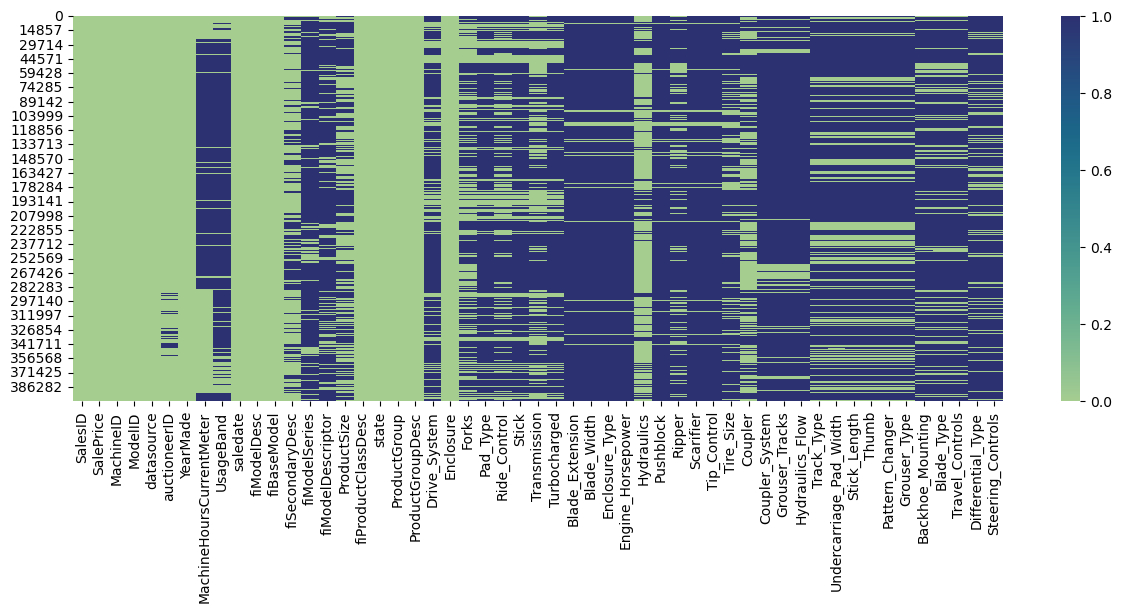

In [79]:
plt.figure(figsize=(15, 5))
sns.heatmap(train_df.isna(), cmap='crest')

In [80]:
train_df = add_datepart(train_df, 'saledate')


In [81]:
def train_cats(df):
    from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
    return df

In [82]:
train_df =  train_cats(train_df)

In [83]:
train_df['UsageBand'].cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [84]:
train_df['UsageBand'].cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

C:\Users\eghan\AppData\Local\Temp\ipykernel_12856\2437915536.py:1: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  train_df['UsageBand'].cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)


In [85]:
train_df['UsageBand'].cat.categories

Index(['High', 'Medium', 'Low'], dtype='object')

In [86]:
cat_columns = train_df.select_dtypes(['category']).columns
train_df[cat_columns] = train_df[cat_columns].apply(lambda x: x.cat.codes)

In [92]:
train_df.fillna(train_df.mean(), inplace=True)


In [87]:
train_df['SalePrice'] = np.log(train_df['SalePrice'])

In [88]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 65 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  float64
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 401125 non-null  int8   
 9   fiModelDesc               401125 non-null  int16  
 10  fiBaseModel               401125 non-null  int16  
 11  fiSecondaryDesc           401125 non-null  int16  
 12  fiModelSeries             401125 non-null  int16  
 13  fiModelDescriptor         401125 non-null  i

In [94]:
from sklearn.ensemble import RandomForestRegressor

In [95]:
X = train_df.loc[:, train_df.columns != 'SalePrice']
y = train_df.loc[:, train_df.columns == 'SalePrice']

In [96]:
rfr = RandomForestRegressor()
rfr.fit(X, y)
rfr.score()

C:\Users\eghan\AppData\Local\Temp\ipykernel_12856\2704032843.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X, y)
